In [1]:
%load_ext autoreload
%autoreload 2

In [66]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from utils import sparsify_beta

from postprocess_utils import *
import pandas as pd
import sqlalchemy

import h5py
from plotting_utils import *

In [3]:
from postprocess import postprocess_run

### Functions 

In [76]:
# Here, indices is a list of lists
def variance_from_file(bfilepath, indices, flag=None):
    variance = np.zeros(len(indices))
    with h5py.File(bfilepath, 'r') as beta_file:
        for i, idx in enumerate(indices):
            bhat = beta_file['beta_hat'][idx, :]
            b = beta_file['beta'][idx, :]
#             b = sparsify_beta(b[:, np.newaxis], df.iloc[i]['block_size'],
#                   df.iloc[i]['sparsity'],seed=df.iloc[i]['block_size'])
            if flag is None:
                variance[i] = np.mean(np.var(bhat, axis=0))
            elif flag == 'true':
                true_support = [np.nonzero(b[j, :])[0] for j in range(len(idx))]  
                pdb.set_trace()
                bhat_true = np.array([bhat[supp, :] for supp in true_support])                
                # This should be true across instantiations
                assert(true_support[0] == true_support[1])                
                variance[i] = np.mean(np.var(bhat_true, axis = 0))
    return variance   

In [78]:
def bias_from_file(bfilepath, indices, df, flag=None):

    bias = np.zeros(len(indices))
    with h5py.File(bfilepath, 'r') as beta_file:
        for i, idx in enumerate(indices):

            b = beta_file['beta'][idx, :]
#             b = sparsify_beta(b[:, np.newaxis], df.iloc[i]['block_size'],
#                               df.iloc[i]['sparsity'],seed=df.iloc[i]['block_size'])
            bhat = beta_file['beta_hat'][idx, :]            

            if flag is None:
                bias[i] = np.linalg.norm(bhat - b)
            elif flag == 'true':
                true_support = np.nonzero(b)[0]
                bias[i] = np.linalg.norm(bhat[true_support] - b[true_support])
            elif flag == 'common':
                common_support = list(set(list(np.nonzero(b)[0])).intersection(
                                      set(list(np.nonzero(bhat)[0]))))
                bias[i] = np.linalg.norm(bhat[common_support] - b[common_support])
    return bias        

### Small Bias Test 2 Verification

In [9]:
# Task 1: verify that smallbiastest2 and smallbiastest2verify give essentially the same results (previously, 
# the resume flag was botched, but this test intends to verify that a completed folder is reliable nonetheless)

In [11]:
# Postprocess smallbiastest2 
sbt2 = postprocess_run('/mnt/sdb1/smallbiastests/smallbiastest2', '/mnt/sdb1/smallbiastests/smallbiastest2/uoi_pp',
                       exp_type=None, fields=['sa', 'ee', 'r2', 'MSE', 'bias', 'FNR', 'FPR'], save_beta=True)\

12800
131.28363275527954


In [12]:
sbt2v = postprocess_run('/mnt/sdb1/smallbiastests/smallbiastest2verify', '/mnt/sdb1/smallbiastests/smallbiastest2verify/uoi_pp',
                       exp_type=None, fields=['sa', 'ee', 'r2', 'MSE', 'bias', 'FNR', 'FPR'], save_beta=True)

12800
137.4785225391388


In [13]:
lasso = postprocess_run('/mnt/sdb1/smallbiastests/smallbiastest', '/mnt/sdb1/smallbiastests/smallbiastest/lasso_pp',
                       exp_type='CV_Lasso', fields=['sa', 'ee', 'r2', 'MSE', 'bias', 'FNR', 'FPR'], save_beta=True)
scad = postprocess_run('/mnt/sdb1/smallbiastests/smallbiastest', '/mnt/sdb1/smallbiastests/smallbiastest/scad_pp',
                       exp_type='scad', fields=['sa', 'ee', 'r2', 'MSE', 'bias', 'FNR', 'FPR'], save_beta=True)
sbt3 = postprocess_run('/mnt/sdb1/smallbiastests/smallbiastest3', '/mnt/sdb1/smallbiastests/smallbiastest3/uoi_pp',
                       exp_type=None, fields=['sa', 'ee', 'r2', 'MSE', 'bias', 'FNR', 'FPR'], save_beta=True)

3200
34.884132862091064
3200
34.400651931762695
16000
168.1904079914093


In [14]:
sparsity = np.unique(sbt2['sparsity'].values)
n_boots_est = np.unique(sbt2['n_boots_est'].values)

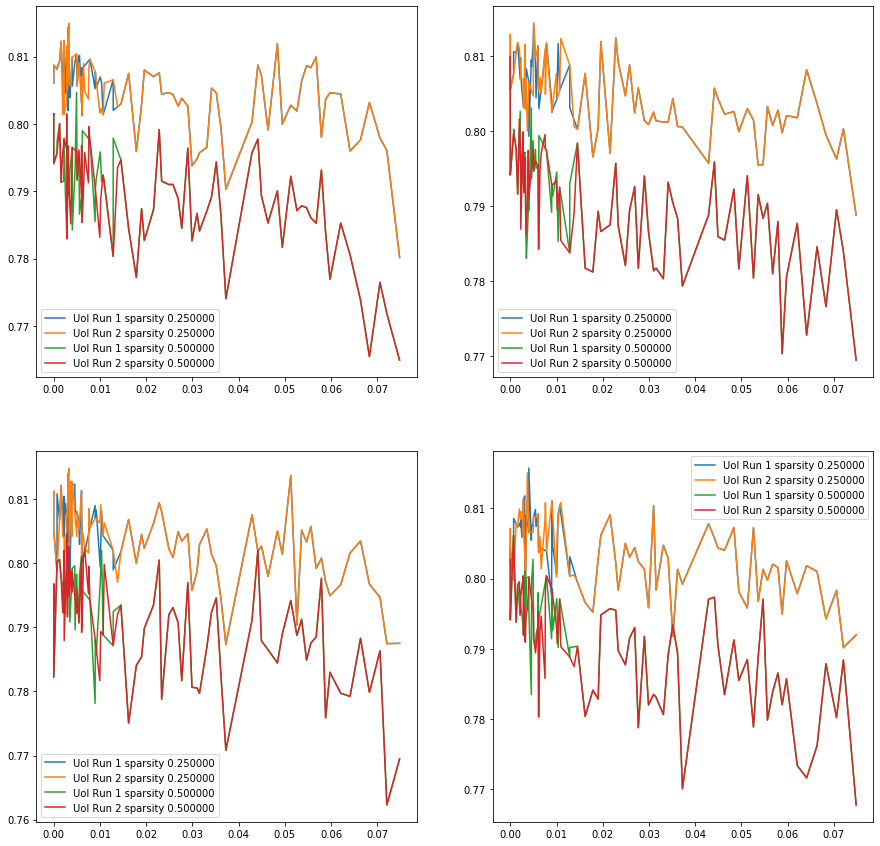

In [19]:
# Some test statistics: selection accuracy across average correlation, bias across average correlation and estimation
# bootstraps. 

# Selection accuracy

fig, ax = plt.subplots(2, 2, figsize=(15, 15))

# Stick with BIC
selection_method = 'CV'

for i1, nbe in enumerate(n_boots_est):
    a = ax[np.unravel_index(i1, (2, 2))]
    
    for i2, s in enumerate(sparsity):
        
        df1 = apply_df_filters(sbt2, sparsity=s, n_boots_est=nbe, selection_method=selection_method)
        df2 = apply_df_filters(sbt2v, sparsity=s, n_boots_est=nbe, selection_method=selection_method)
        
        # Average over reps for each unique cov param
        ucp, cidxs = unique_cov_params(df1)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        
        values = df1['r2'].values 
        averaged_values = np.array([np.mean(values[cidx]) for cidx in cidxs])        
        a.plot(avg_cov[cov_order], averaged_values[cov_order], label='UoI Run 1 sparsity %f' % s)

        # Average over reps for each unique cov param
        ucp, cidxs = unique_cov_params(df2)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        
        values = df2['r2'].values 
        averaged_values = np.array([np.mean(values[cidx]) for cidx in cidxs])        
        a.plot(avg_cov[cov_order], averaged_values[cov_order], label='UoI Run 2 sparsity %f' % s)

    a.legend()
    

In [ ]:
# Good enough!

In [ ]:
# Task 2: Compare the bias of UoI against SCAD and Lasso across standard conditions 
# for the different selection methods and sparsities, vs. average correlation

# Total bias
# Bias on the true parameters
# Bias on correctly chosen support

# Total variance 
# Variance on the true parameters
# Variance on the correctly chosen support

In [28]:
root_dir = '/mnt/sdb1/smallbiastests'

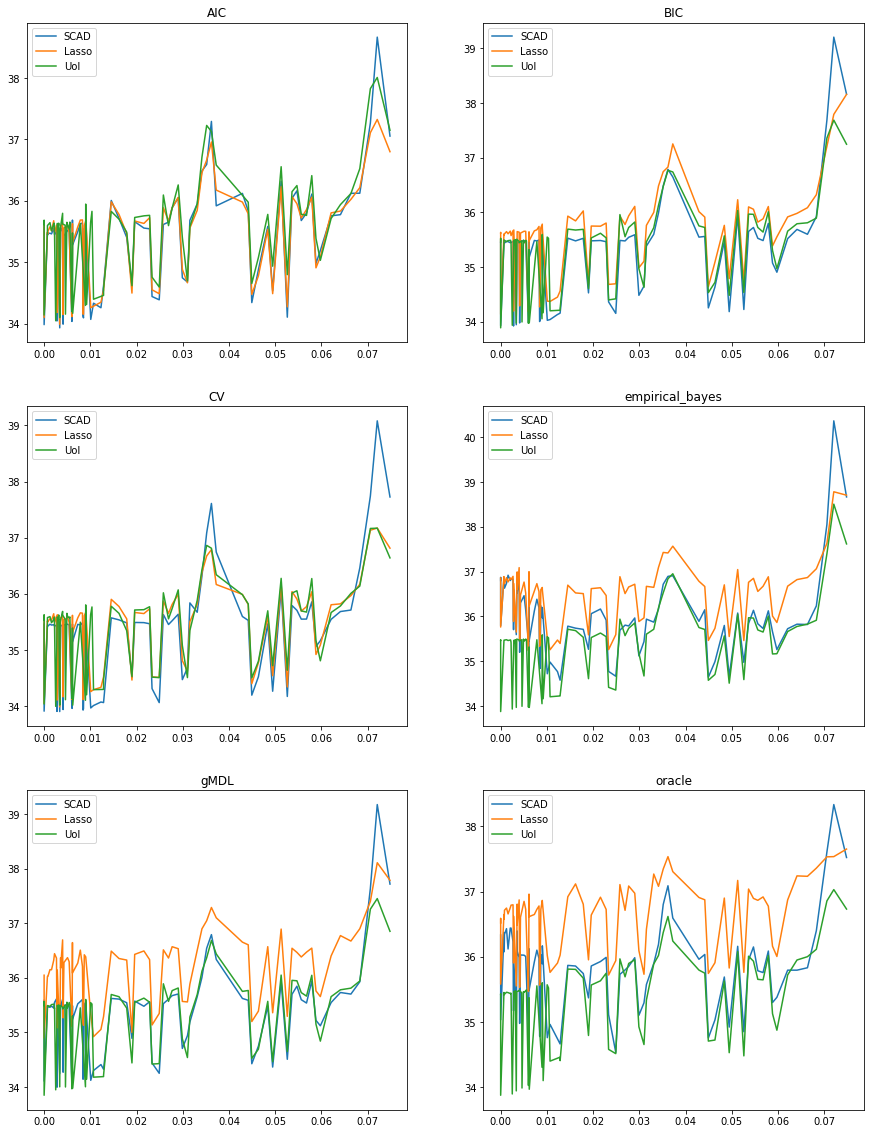

In [79]:
# Total bias, sparsity = 0.25

# Need to sparsify beta you fucking dipshit!

fig, ax = plt.subplots(3, 2, figsize = (15, 20))
uoi = apply_df_filters(sbt2, n_boots_est=25)
dframes = [scad, lasso, uoi]

beta_files = [root_dir + '/smallbiastest/scad_pp_beta.h5', 
              root_dir + '/smallbiastest/lasso_pp_beta.h5', 
              root_dir + '/smallbiastest2/uoi_pp_beta.h5']

dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad['selection_method'].values)):
    
    a = ax[np.unravel_index(i, (3, 2))]
       
    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        
        # Average values over cidxs
        values = bias_from_file(beta_files[i2], list(df_.index), df_)
        averaged_values = np.array([np.mean(values[cidx]) for cidx in cidxs])        
        a.plot(avg_cov[cov_order], averaged_values[cov_order], label=dframe_names[i2])
    a.set_title(sm)
    a.legend()


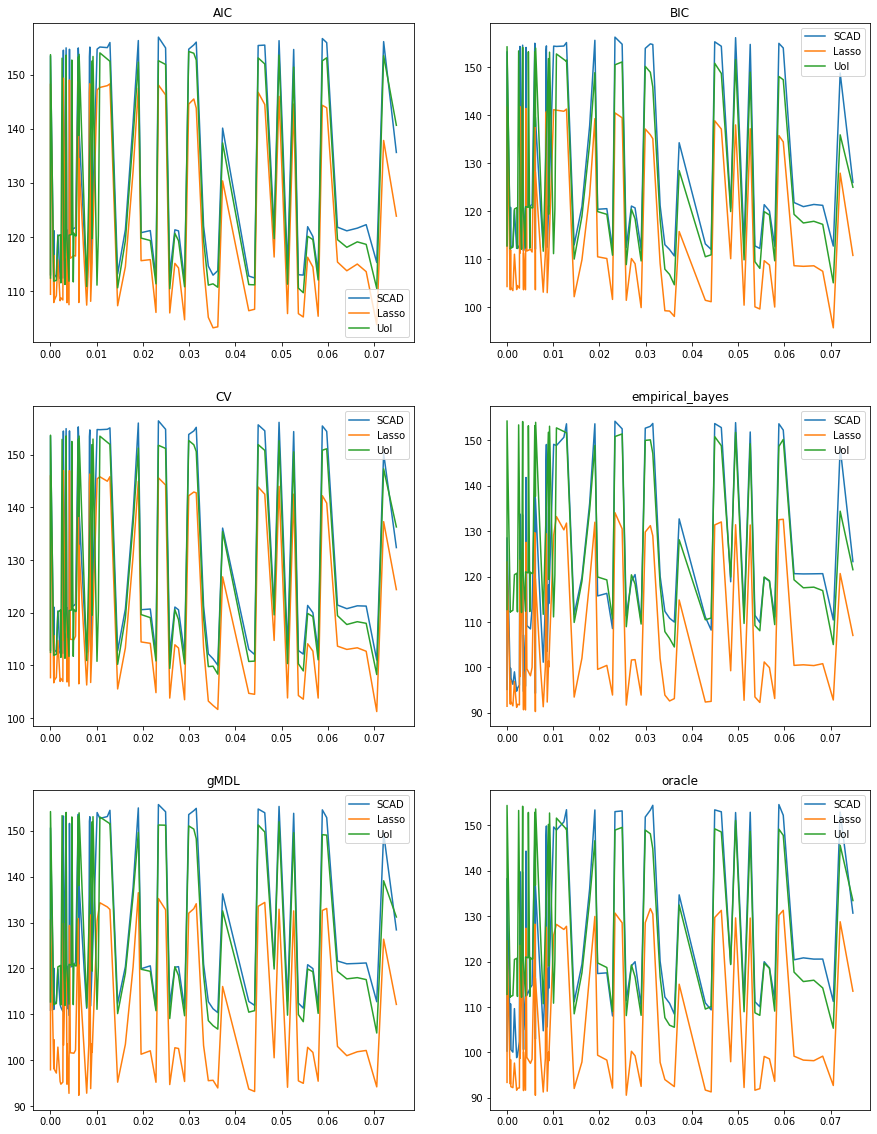

In [73]:
# Bias on the true model coefficients
fig, ax = plt.subplots(3, 2, figsize = (15, 20))
uoi = apply_df_filters(sbt2, n_boots_est=25)
dframes = [scad, lasso, uoi]
beta_files = [root_dir + '/smallbiastest/scad_pp_beta.h5', 
              root_dir + '/smallbiastest/lasso_pp_beta.h5', 
              root_dir + '/smallbiastest2/uoi_pp_beta.h5']
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]
    
    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        
        # Average values over cidxs
        values = bias_from_file(beta_files[i2], list(df_.index), df_, flag='true')
        averaged_values = np.array([np.mean(values[cidx]) for cidx in cidxs])        
        a.plot(avg_cov[cov_order], averaged_values[cov_order], label=dframe_names[i2])
    a.set_title(sm)
    a.legend()


TypeError: bias_from_file() missing 1 required positional argument: 'df'

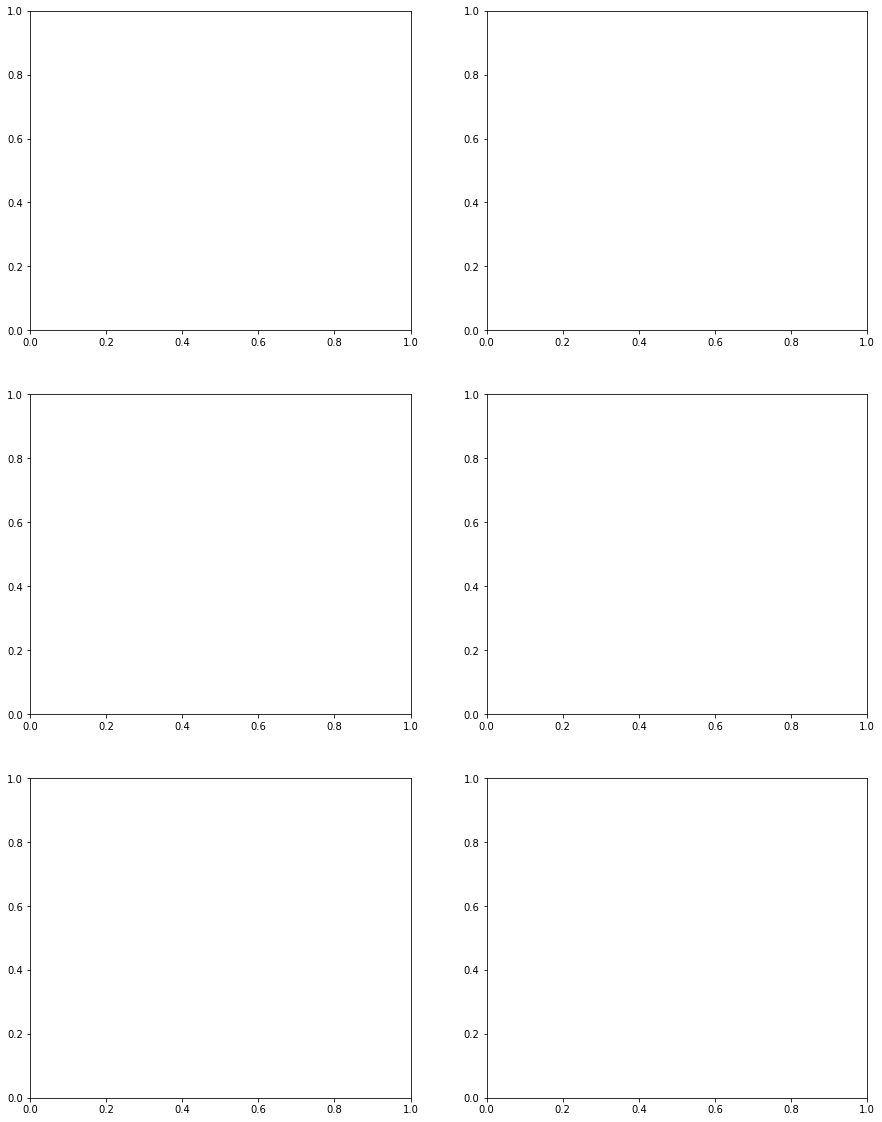

In [75]:
# Bias on the common model coefficients
fig, ax = plt.subplots(3, 2, figsize = (15, 20))
uoi = apply_df_filters(sbt2, n_boots_est=25)
dframes = [scad, lasso, uoi]
beta_files = [root_dir + '/smallbiastest/scad_pp_beta.h5', 
              root_dir + '/smallbiastest/lasso_pp_beta.h5', 
              root_dir + '/smallbiastest2/uoi_pp_beta.h5']
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]
    
    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[0])
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)
        
        # Average values over cidxs
        values = bias_from_file(beta_files[i2], list(df_.index), flag='common')
        averaged_values = np.array([np.mean(values[cidx]) for cidx in cidxs])        
        a.plot(avg_cov[cov_order], averaged_values[cov_order], label=dframe_names[i2])
    a.set_title(sm)
    a.legend()


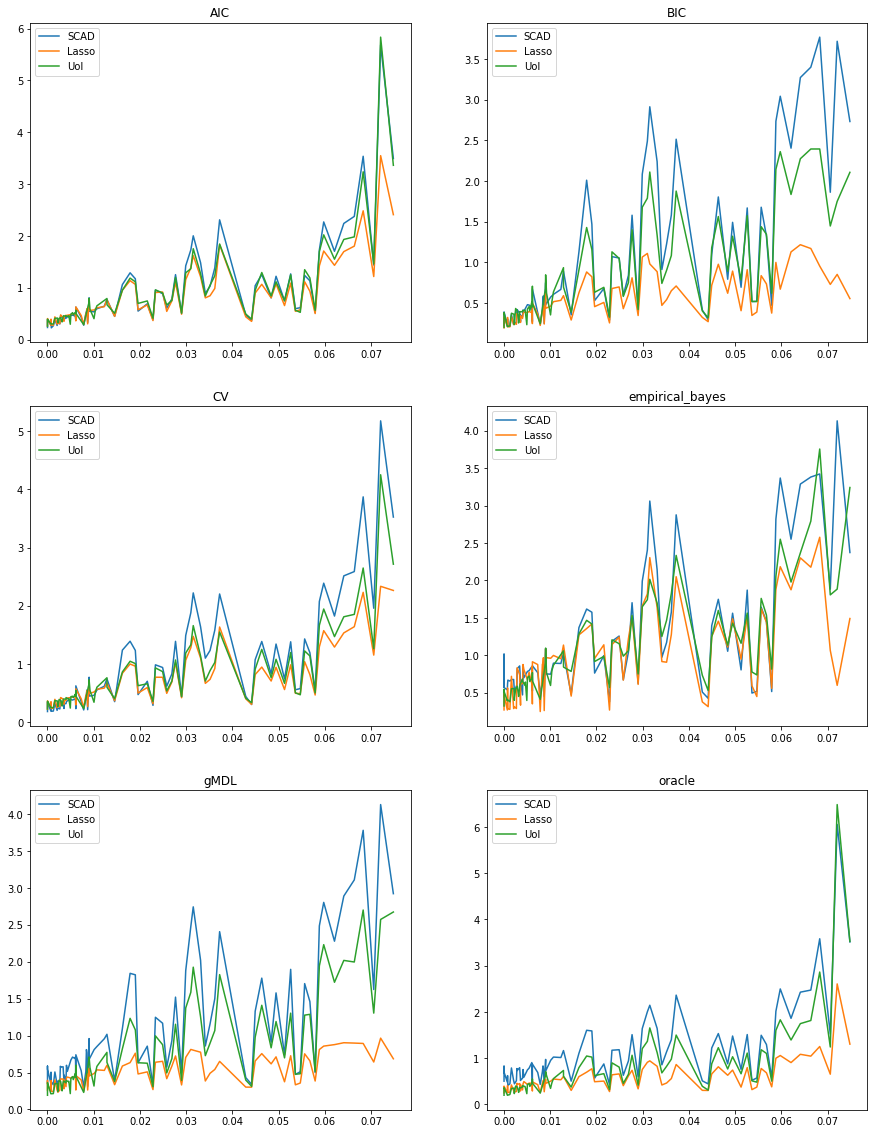

In [52]:
# Total variance --> Note the sparsity here!
fig, ax = plt.subplots(3, 2, figsize = (15, 20))
uoi = apply_df_filters(sbt2, n_boots_est=25)
dframes = [scad, lasso, uoi]
beta_files = [root_dir + '/smallbiastest/scad_pp_beta.h5', 
              root_dir + '/smallbiastest/lasso_pp_beta.h5', 
              root_dir + '/smallbiastest2/uoi_pp_beta.h5']
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]
    
    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[1])
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)

        # Need to arrange the indices of the original dataframe from which df_
        # is extracted in groupings by the reps
        df_index = list(df_.index)
        df_index_by_rep = [[df_index[j] for j in rep_idx] for rep_idx in cidxs]        
        # Average values over cidxs
        values = variance_from_file(beta_files[i2], df_index_by_rep)
        a.plot(avg_cov[cov_order], values[cov_order], label=dframe_names[i2])
       
    a.set_title(sm)
    a.legend()


> <ipython-input-60-2ab0386569ee>(13)variance_from_file()
-> bhat_true = np.array([bhat[supp, :] for supp in true_support])
(Pdb) true_support
[array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99]), array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92

(Pdb) true_support[0]
array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])
(Pdb) !b
array([[-4.521952 ,  3.6118612, -2.9637964, ...,  4.5559554, -4.879988 ,
         3.9308932],
       [-4.521952 ,  3.6118612, -2.9637964, ...,  4.5559554, -4.879988 ,
         3.9308932],
       [-4.521952 ,  3.6118612, -2.9637964, ...,  4.5559554, -4.879988 ,
         3.9308932],
       ...,
       [-4.521952 ,  3.6118612, -2.9637964, ...,  4.5559554, -4.879988 ,
         3.9308932],
       [-4.521952 ,  3.6118612, -2.9637964, ...,  4.5559554, -4.879988 ,
         3.9308932],
       [-4.521952 ,  3.6118612, -2.9637964, 

BdbQuit: 

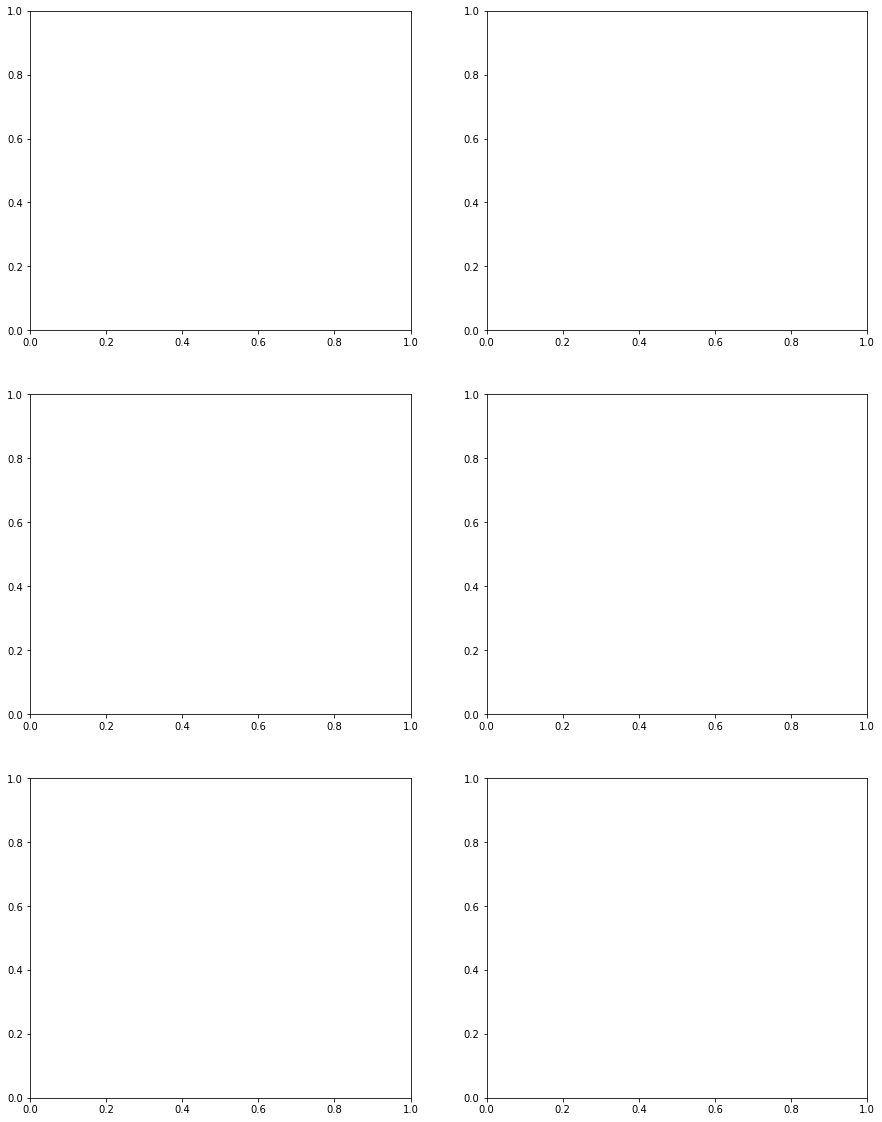

In [61]:
# Variance on true support, note the sparsity!
fig, ax = plt.subplots(3, 2, figsize = (15, 20))
uoi = apply_df_filters(sbt2, n_boots_est=25)
dframes = [scad, lasso, uoi]
beta_files = [root_dir + '/smallbiastest/scad_pp_beta.h5', 
              root_dir + '/smallbiastest/lasso_pp_beta.h5', 
              root_dir + '/smallbiastest2/uoi_pp_beta.h5']
dframe_names = ['SCAD', 'Lasso', 'UoI']
                
for i, sm in enumerate(np.unique(scad['selection_method'].values)):

    a = ax[np.unravel_index(i, (3, 2))]
    
    for i2, df in enumerate(dframes):    
        df_ = apply_df_filters(df, selection_method=sm, sparsity=sparsity[1])
        ucp, cidxs = unique_cov_params(df_)
        avg_cov = np.array([calc_avg_cov(500, **cp) for cp in ucp])
        cov_order = np.argsort(avg_cov)

        # Need to arrange the indices of the original dataframe from which df_
        # is extracted in groupings by the reps
        df_index = list(df_.index)
        df_index_by_rep = [[df_index[j] for j in rep_idx] for rep_idx in cidxs]        
        # Average values over cidxs
        values = variance_from_file(beta_files[i2], df_index_by_rep, flag='true')
        a.plot(avg_cov[cov_order], values[cov_order], label=dframe_names[i2])
       
    a.set_title(sm)
    a.legend()


In [21]:
# Task 3: Compare the effects of changing the number of estimation bootstraps and adding
# L2 penalty. 

# Finally, if some variation is chosen, verify that the selection accuracy and the R2
# are unaffected